In [1]:
# all needed imports here
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow_addons as tfa

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import cv2
import itertools
import os
import shutil
import glob
import random
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline


# checking if GPU is enabled in Kaggle notebook/available
hardware_list = tf.config.list_physical_devices(
    device_type=None
)

print(hardware_list)

gpu_test = tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
print("GPU Available:", gpu_test)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Available: True


# EDA

In [2]:
# checking how many files/samples are in each class
path = '../input/diabetic-retinopathy-resized-arranged/4'
num_files = len([f for f in os.listdir(path)
                if os.path.isfile(os.path.join(path, f))])
# print(num_files)

"""
NUMBER OF FILES IN EACH CLASS

0 - 25810
1 - 2443
2 - 5294
3 - 873
4 - 708
"""

'\nNUMBER OF FILES IN EACH CLASS\n\n0 - 25810\n1 - 2443\n2 - 5294\n3 - 873\n4 - 708\n'

* cannot do percentage splits to make training/valid/test sets because the original dataset is imbalanced
    * will be dominated by class 0 instances in all sets\
* resort to fixed sizes

# Creating train, test, and validation sets + Preprocessing

In [3]:
# PREPROCESSING PARAMS
TRAIN_SIZE = 700
TEST_SIZE = 700
VALID_SIZE = 700

In [4]:
"""
- creating the different sets with respective percentages
- NOTE: dataset is imbalanced, used a fixed size of 700 for each set
"""

original_data_path = "../input/diabetic-retinopathy-resized-arranged"
# train_pct = 0.7
# test_pct = 0.1
# valid_pct = 0.2

os.chdir("./")
if os.path.isdir("train/0") is False:
    # create folders for the sets
    os.mkdir("./train")
    os.mkdir("./test")
    os.mkdir("./valid")
    
    # move X number of instances from original set, to respective sets
    for i in range(0, 5):
        # path to inputs with different classes
        num_folder_path = f'{original_data_path}/{i}' 
        num_files_in_folder = len(os.listdir(num_folder_path))
#         train_size = int(num_files_in_folder * train_pct)
#         test_size = int(num_files_in_folder * test_pct)
#         valid_size = int(num_files_in_folder * valid_pct)
        train_size = TRAIN_SIZE
        test_size = TEST_SIZE
        valid_size = VALID_SIZE
        
        # make classes within set
        os.mkdir(f'train/{i}')
        os.mkdir(f'test/{i}')
        os.mkdir(f'valid/{i}')
        
        test_samples = random.sample(os.listdir(num_folder_path), test_size)
        for file_name in test_samples:
            shutil.copy((f"../input/diabetic-retinopathy-resized-arranged/{i}/{file_name}"), f'./test/{i}')

        train_samples = random.sample(os.listdir(num_folder_path), train_size)
        for file_name in train_samples:
            shutil.copy((f"../input/diabetic-retinopathy-resized-arranged/{i}/{file_name}"), f'./train/{i}')
            
        valid_samples = random.sample(os.listdir(num_folder_path), valid_size)
        for file_name in valid_samples:
            shutil.copy((f"../input/diabetic-retinopathy-resized-arranged/{i}/{file_name}"), f'./valid/{i}')
        

## preprocessing functions

In [5]:
# train,test, and valid set paths
TRAIN_PATH = "./train"
TEST_PATH = "./test"
VALID_PATH = "./valid"

In [6]:
# preprocessing/augmentation for ImageDataGenerator
def preprocesser(image):
    image= tf.image.adjust_contrast(image, 0.6)
    image = tfa.image.equalize(image)
    image = tf.image.rgb_to_grayscale(image)
    return image

In [7]:
# generating sets
PREPROCESSING_FUNC = preprocesser
CLASS_MODE = "categorical"
BATCH_SIZE = 32

train_batches = ImageDataGenerator(preprocessing_function = PREPROCESSING_FUNC, rescale=1./255, horizontal_flip=True).flow_from_directory(directory = TRAIN_PATH, target_size = (224,224), batch_size = BATCH_SIZE, class_mode=CLASS_MODE)
test_batches = ImageDataGenerator(preprocessing_function = PREPROCESSING_FUNC, rescale=1./255).flow_from_directory(directory = TEST_PATH, target_size = (224,224), batch_size = BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False)
valid_batches = ImageDataGenerator(preprocessing_function = PREPROCESSING_FUNC, rescale=1./255).flow_from_directory(directory = VALID_PATH, target_size = (224,224), batch_size = BATCH_SIZE, shuffle = False, class_mode=CLASS_MODE)

Found 3500 images belonging to 5 classes.
Found 3500 images belonging to 5 classes.
Found 3500 images belonging to 5 classes.


In [8]:
# checking if ImageDataGenerator assigned proper labels
train_batches.labels

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


<Figure size 432x288 with 0 Axes>

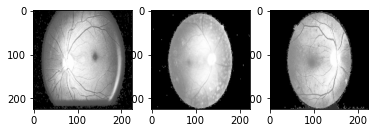

In [9]:
# what the inputs/images look like after augmentation

plt.figure()
f, axarr = plt.subplots(1,3)
for i in range (0,3):
    random_num = random.randint(0,100)
    image = train_batches[random_num]
    axarr[i].imshow(image[0][0])
    print(np.shape(image[0][0])) # 224x224x3, needed to put into MobileNetV2

# Model Building

## FIRST PASS/TRANSFER LEARNING

In [10]:
# MODEL PARAMS - change here
NUM_EPOCH = 50
LEARNING_RATE = 0.001
FREEZE_LAYERS = -6
LOSS_FUNC = "categorical_crossentropy"
TRAIL_NUM = 1
SECOND_PASS = False # change to True when fine tuning after training new output layer
PATIENCE = 25

In [11]:
# importing MobileNetv2 - original, excluding the final/output layer
model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [12]:
for layer in model.layers: # originally 23
    layer.trainable = SECOND_PASS # should be False on first run 

In [13]:
# adding new output layer to MobileNetV2, specific to our problem
x = Flatten()(model.output)
output = Dense(units=5, activation="softmax")(x) # 5 units for, 1 for each class

In [14]:
model = Model(inputs = model.input, outputs = output)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [16]:
# number of training params in MobileNetV2 model with new output layer
trainable_params_freeze = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
non_trainable_params_freeze = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
print(f"trainable params: {trainable_params_freeze}\nnon trainable params: {non_trainable_params_freeze}")

trainable params: 313605
non trainable params: 2257984


## model training -> train then save

trained 30 epoch model, no need to train again. Unless tweaks are made to params

In [17]:
model.compile(optimizer=Adam(lr=LEARNING_RATE), loss=LOSS_FUNC, metrics=["accuracy"])

In [18]:
# early stopping enabled, controlled with PATIENCE variable
model.fit_generator(train_batches, validation_data=valid_batches, epochs=NUM_EPOCH, verbose=2, callbacks=EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
110/110 - 124s - loss: 6.9221 - accuracy: 0.3200 - val_loss: 5.7624 - val_accuracy: 0.3363
Epoch 2/50
110/110 - 114s - loss: 4.9131 - accuracy: 0.4526 - val_loss: 5.5475 - val_accuracy: 0.4126
Epoch 3/50
110/110 - 114s - loss: 3.3516 - accuracy: 0.5543 - val_loss: 4.7768 - val_accuracy: 0.4671
Epoch 4/50
110/110 - 114s - loss: 2.7068 - accuracy: 0.6203 - val_loss: 4.7599 - val_accuracy: 0.5069
Epoch 5/50
110/110 - 114s - loss: 2.0002 - accuracy: 0.6791 - val_loss: 3.9156 - val_accuracy: 0.5183
Epoch 6/50
110/110 - 118s - loss: 1.9252 - accuracy: 0.7126 - val_loss: 3.8904 - val_accuracy: 0.5414
Epoch 7/50
110/110 - 115s - loss: 1.8168 - accuracy: 0.7274 - val_loss: 4.2319 - val_accuracy: 0.5323
Epoch 8/50
110/110 - 115s - loss: 1.2952 - accuracy: 0.7754 - val_loss: 4.4046 - val_accuracy: 0.5409
Epoch 9/50
110/110 - 115s - loss: 1.1242 - accuracy: 0.7946 - val_loss: 4.7127 - val_accuracy: 0.5234
Epoch 10/50
110/110 - 117s - loss: 1.3875 - accuracy: 0.7837 - val_loss: 5.4166 - 

## SECOND PASS/FINE TUNING

In [19]:
# # MODEL PARAMS - second pass
# NUM_EPOCH = 5
# LEARNING_RATE = 0.0001
# TRAIL_NUM = 2

In [20]:
# for layer in model.layers[:FREEZE_LAYERS]:
#     layer.trainable = True

In [21]:
# model.compile(optimizer=Adam(lr=0.0001), loss=LOSS_FUNC, metrics=["accuracy"])

In [22]:
# model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

## saving model 

In [23]:
# can save model after first or second run 
SAVE_LOC = f'./trial{TRAIL_NUM}'

In [24]:
model.save(SAVE_LOC, save_format="h5")

# Performance Evaluations

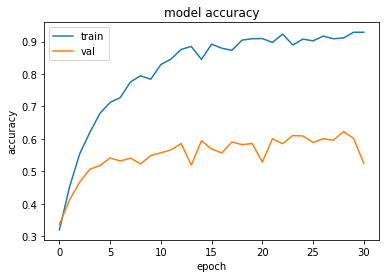

In [25]:
# only needed if training, use after training

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

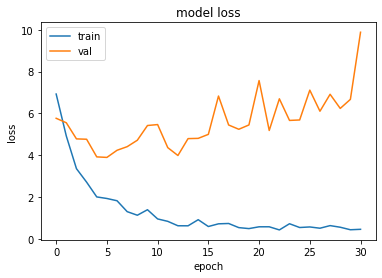

In [26]:
# only needed if training, use after training

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Load existing model

In [27]:
# proper labels 
proper_labels = {
    0: "no DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

In [28]:
# get actual class of a single instance

def actual_class(img_path):
    path = os.path.dirname(img_path)
    class_num = path[-1]
    real_class = proper_labels.get(int(class_num))
    return (real_class, class_num)

In [29]:
# loading already trained model via path
trained_model_path = "../input/final-model/good"
loaded_model = keras.models.load_model(trained_model_path)

## confusion matrix for test set 

must create test set before running the following cells

In [30]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
# evaluation -> loss, acc (from keras)
test_eval = loaded_model.evaluate(test_batches, verbose=0)
print(f'test loss, test acc: {test_eval}')

test loss, test acc: [3.923013925552368, 0.6085714101791382]


In [32]:
# prediction -> confusion matrix (custom function)
predictions = loaded_model.predict(test_batches, verbose=0)

In [33]:
test_labels = test_batches.classes
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

Confusion matrix, without normalization
[[279 162 176  48  35]
 [175 333 147  29  16]
 [164 111 298  76  51]
 [ 29  27  73 544  27]
 [  3   2  13   6 676]]


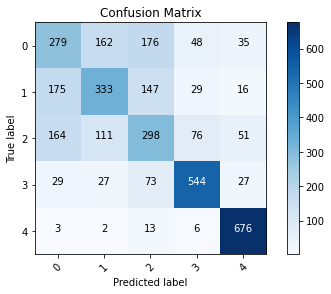

In [34]:
cm_plot_labels = ["0", "1", "2", "3", "4"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

In [35]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

pred_arr = predictions.argmax(1)

test_acc = accuracy_score(y_true=test_labels, y_pred=pred_arr)
test_recall = recall_score(y_true=test_labels, y_pred=pred_arr, average="macro")
test_precision = precision_score(y_true=test_labels, y_pred=pred_arr, average="macro")

print(f'acc: {test_acc}, recall: {test_recall}, precision: {test_precision}')

acc: 0.6085714285714285, recall: 0.6085714285714287, precision: 0.5977435043336208


In [36]:
from sklearn.metrics import roc_curve, auc, f1_score
test_f1_score = f1_score(test_labels, pred_arr, average="macro")

fpr, tpr, thresholds = roc_curve(test_labels, pred_arr, pos_label=0) # auc for class 0
test_auc = auc(fpr, tpr)

print(f'AUC: {test_auc}')

AUC: 0.2610645408163265


In [37]:
# removing all models from current kernel
# keras.backend.clear_session()